<a href="https://colab.research.google.com/github/vlad-danaila/ml-cancer-detection/blob/master/Cancer_Detection_Ensable_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install sklearn matplotlib GPUtil

In [ ]:
!pip3 install "pillow<7"

In [ ]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html

**Download Data**

Mount my google drive, where the dataset is stored.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print(e)

Unzip the dataset into the folder "dataset".

In [ ]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

**Constants**

In [1]:
# TRAIN_PATH = '/content/dataset/data/train/'
# TEST_PATH = '/content/dataset/data/test/'
TRAIN_PATH = 'dataset/data/train/'
TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

# prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
prefix = 'Mobilenetv2 Tuning/'
CHACKPOINT_CROSS_ENTROPY_MODEL = prefix + 'checkpint vgg19 baseline.tar'

**Imports**

In [2]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import statistics
import math

**Deterministic Measurements**

This statements help making the experiments reproductible by fixing the random seeds.

In [3]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Memory Stats**

In [4]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB
GPU RAM Free: 11019MB | Used: 0MB | Util   0% | Total 11019MB


**Loading Data**

The dataset is structured in multiple small folders, ecah containing 7 images. The generator iterates through the folders and returns the category and 7 paths: one for each image in the folder.

In [5]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 3 datasets, which loads 3 kinds of images: natural images, images taken through a green lens and images where the doctor aplied iodine solution (which gives a dark red colour). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [6]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [7]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [8]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [9]:
def create_loaders(dataset_class):
  dataset_train = dataset_class(TRAIN_PATH, transforms_x_dynamic = transforms_train, transforms_y_dynamic = y_transform)
  dataset_test = dataset_class(TEST_PATH, transforms_x_static = transforms_test, 
                                                transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [10]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders(SimpleImagesDataset)

**Visualize Data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [11]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [12]:
# x, y = next(iter(loader_train_simple_img))
# for i in range(7):
#   plot_predictions(x[i], y, y)

**Model**

In [13]:
def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[6].out_features = 4
  return model

In [14]:
model_simple = t.nn.DataParallel(get_vgg_19())

**Train & Evaluate**

Timer utility function. This is used to measure the execution speend.

In [15]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and e valuates it at the same time. It outputs the metrics recorder during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is imporved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [16]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': [],

      'mean_class_acc_train': [],
      'mean_class_acc_test': []  
  }

  best_mean_acc = 0
  
  loss_weights = t.tensor([1/4] * 4, device='cuda:0')
    
  try:  
    for epoch in range(epochs):
      timer_start()
      loss_fn = t.nn.CrossEntropyLoss(weight = loss_weights)
      # loss_fn = t.nn.CrossEntropyLoss()
      # loss_fn = FocalLoss(gamma = 2)
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      conf_matrix = np.zeros((4, 4))
      for x, y in loader_train:
        y_pred = model.forward(x)
        y_pred = y_pred.narrow(1, 0, 4)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
        conf_matrix += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      mean_class_acc = statistics.harmonic_mean(class_acc)
      errors = [1 - conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
      errors_strong = [math.exp(e) for e in errors]
      loss_weights = t.tensor([e / sum(errors_strong) for e in errors_strong], device = 'cuda:0')
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
      metrics['mean_class_acc_train'].append(mean_class_acc) 

      # Evaluate
      model.eval()
      with t.no_grad():
        conf_matrix_test = np.zeros((4, 4))
        for x, y in loader_test:
          y_pred = model.forward(x)
          y_pred = y_pred.narrow(1, 0, 4)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
          conf_matrix_test += sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
        class_acc_test = [conf_matrix_test[i][i] / sum(conf_matrix_test[i]) for i in range(len(conf_matrix_test))]
        mean_class_acc_test = statistics.harmonic_mean(class_acc_test)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
        metrics['mean_class_acc_test'].append(mean_class_acc_test) 
      
      if metrics['mean_class_acc_test'][-1] > best_mean_acc:
        best_mean_acc = metrics['mean_class_acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} mean class acc {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['mean_class_acc_test'][-1], metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [17]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

In [18]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [19]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['mean_class_acc_test']).argmax()
    print('Best mean class accuracy :', metrics['mean_class_acc_test'][index_max])
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['mean_class_acc_train'], metrics['mean_class_acc_test'], 'Mean Class Accuracy (lr = {})'.format(learn_rate), 'Mean Class Accuracy')
    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

Perform actual training

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.6/statistics.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))


Epoch 1 mean class acc 0.0 acc 0.29166666666666663 prec 0.2680417700578991 rec 0.1556712962962963 f 0.1395538967215595 minutes 0.5605320811271668
Epoch 2 mean class acc 0.0 acc 0.36250000000000004 prec 0.2972623124592303 rec 0.18518518518518517 f 0.1848707993587283 minutes 0.4220081488291422
Epoch 3 mean class acc 0.05455614344503233 acc 0.35000000000000003 prec 0.36522108843537415 rec 0.18750000000000003 f 0.20263509426353465 minutes 0.4306225538253784
Epoch 4 mean class acc 0.29808855552867164 acc 0.44166666666666665 prec 0.5005393571570043 rec 0.25243055555555555 f 0.3017677974480045 minutes 0.4381539146105448
Epoch 5 mean class acc 0.23133748055987557 acc 0.4833333333333334 prec 0.5021043771043772 rec 0.27951388888888895 f 0.32364457183845624 minutes 0.4296006520589193
Epoch 6 mean class acc 0.47605944798301486 acc 0.5208333333333334 prec 0.47003673714200034 rec 0.3096064814814815 f 0.36095367958113056 minutes 0.44435160160064696
Epoch 7 mean class acc 0.41133263378803775 acc 0.491

Epoch 53 mean class acc 0.5706203390777309 acc 0.6041666666666667 prec 0.4949960540401884 rec 0.38125000000000003 f 0.4273741647224722 minutes 0.4340810497601827
Epoch 54 mean class acc 0.5578956370042245 acc 0.6041666666666667 prec 0.41232164541590777 rec 0.3260416666666667 f 0.3610156164742683 minutes 0.4307057539621989
Epoch 55 mean class acc 0.5577067721536618 acc 0.6125 prec 0.4841378096626742 rec 0.3710648148148149 f 0.41258440540194574 minutes 0.43439203103383384
Epoch 56 mean class acc 0.5391705069124424 acc 0.5833333333333334 prec 0.47634655514504654 rec 0.3524305555555556 f 0.39735130260612894 minutes 0.4302111585934957
Epoch 57 mean class acc 0.49386979796235536 acc 0.55 prec 0.4882605820105821 rec 0.335300925925926 f 0.38843651050961175 minutes 0.44156887928644817
Epoch 58 mean class acc 0.5841906982244522 acc 0.6250000000000001 prec 0.5130208333333333 rec 0.3842592592592593 f 0.43111842607810347 minutes 0.4333654761314392
Epoch 59 mean class acc 0.588545913414871 acc 0.629

Epoch 105 mean class acc 0.5006297685057838 acc 0.5666666666666667 prec 0.395185531214943 rec 0.29409722222222223 f 0.33004510372974305 minutes 0.43261479139328
Epoch 106 mean class acc 0.5475044628803345 acc 0.6125 prec 0.48039701991907874 rec 0.38078703703703703 f 0.4178216813020734 minutes 0.43251328070958456
Epoch 107 mean class acc 0.506570088318358 acc 0.5875 prec 0.39367937612377346 rec 0.31093750000000003 f 0.34132443321684464 minutes 0.432261844476064
Epoch 108 mean class acc 0.5517836142689142 acc 0.6041666666666667 prec 0.4779316130019455 rec 0.36284722222222215 f 0.4046963063304859 minutes 0.4347079277038574
Epoch 109 mean class acc 0.5230115550028499 acc 0.5958333333333333 prec 0.4757206962312597 rec 0.36099537037037044 f 0.40096284496754037 minutes 0.4312580784161886
Epoch 110 mean class acc 0.5667180236768986 acc 0.6041666666666666 prec 0.4687324635241302 rec 0.366087962962963 f 0.40699389339514647 minutes 0.4346859852472941
Epoch 111 mean class acc 0.5372981917031083 ac

Epoch 157 mean class acc 0.5194128376617737 acc 0.5791666666666667 prec 0.45666142439018254 rec 0.36377314814814815 f 0.3978669950250413 minutes 0.43572161595026654
Epoch 158 mean class acc 0.4822712933753943 acc 0.5625 prec 0.4386374230673087 rec 0.355787037037037 f 0.38658232477261756 minutes 0.43273377418518066
Epoch 159 mean class acc 0.5092366849382312 acc 0.5791666666666666 prec 0.40513362388362395 rec 0.3114583333333334 f 0.3406828550728895 minutes 0.42965341806411744
Epoch 160 mean class acc 0.4752306049130984 acc 0.5666666666666667 prec 0.45245974672251765 rec 0.3490740740740741 f 0.37694916576103416 minutes 0.4369988640149434
Epoch 161 mean class acc 0.5052207486990096 acc 0.575 prec 0.45404983813700917 rec 0.3618055555555556 f 0.39349676759097046 minutes 0.44034567674001057
Epoch 162 mean class acc 0.5562584632478039 acc 0.6 prec 0.47734135600853045 rec 0.37430555555555556 f 0.4134676661806949 minutes 0.4455247720082601
Epoch 163 mean class acc 0.5161355529131986 acc 0.58333

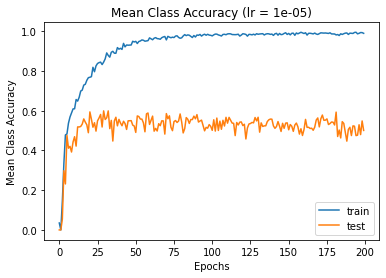

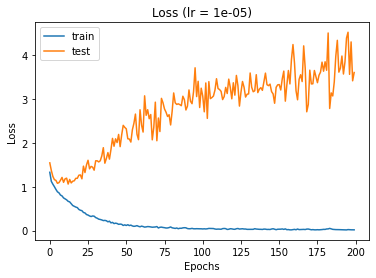

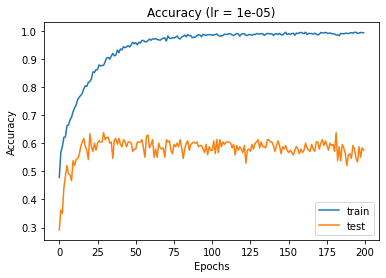

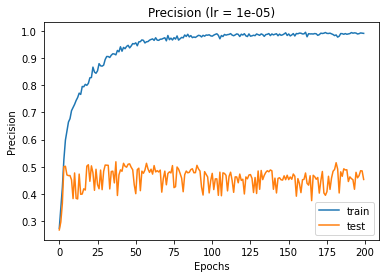

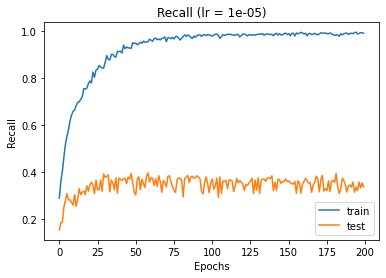

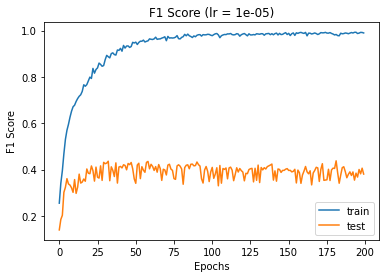

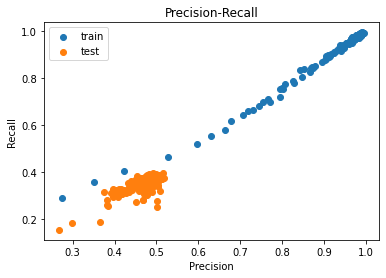

In [20]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'wce vgg19', [(200, 1e-5)])

In [21]:
checkpoint = t.load('checkpint wce vgg19.tar')
model_simple.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [22]:
def calculate_class_acc_for_test_set(model):
  model.eval()
  with t.no_grad():
    conf_matrix = np.zeros((4, 4))
    for x, y in loader_test_simple_img:
      y_pred = model.forward(x)
      y_pred = y_pred.narrow(1, 0, 4)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      cm = sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      conf_matrix += cm
    print('Confusion matrix:\n', conf_matrix)
    class_acc = [conf_matrix[i][i] / sum(conf_matrix[i]) for i in range(len(conf_matrix))]
    print('Class acc:\n', class_acc)
    return class_acc

def plot_class_acc(class_acc):
  plt.bar(list(range(4)), class_acc, align='center', alpha=0.5)
  plt.xticks(list(range(4)), list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.savefig('AccPerClass.pdf', dpi = 300, format = 'pdf')
  plt.show()

def plot_class_acc_comparison(class_acc_1, class_acc_2, title_1, title_2):
  width = .3
  plt.bar(list(range(4)), class_acc_1, width, alpha=0.5, color = 'green', label = title_1)
  plt.bar(np.array(list(range(4))) + width, class_acc_2, width, alpha=0.5, color = 'blue', label = title_2)
  plt.xticks(np.array(list(range(4))) + width/2, list(range(4)))
  plt.xlabel('Classes')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.savefig('ClassAccCompareDenseNet.pdf', dpi = 300, format = 'pdf')
  plt.show()

Confusion matrix:
 [[50.  3.  7.  0.]
 [20. 28. 12.  0.]
 [14. 14. 30.  2.]
 [ 2.  1. 12. 45.]]
Class acc:
 [0.8333333333333334, 0.4666666666666667, 0.5, 0.75]


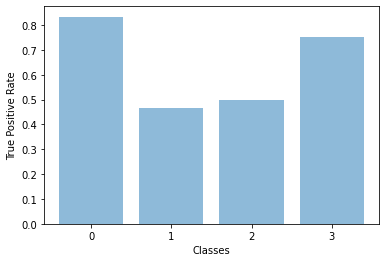

In [23]:
class_acc = calculate_class_acc_for_test_set(model_simple)
plot_class_acc(class_acc)

Confusion matrix:
 [[53.  3.  2.  2.]
 [24. 20. 16.  0.]
 [17.  6. 36.  1.]
 [ 5.  0.  6. 49.]]
Class acc:
 [0.8833333333333333, 0.3333333333333333, 0.6, 0.8166666666666667]


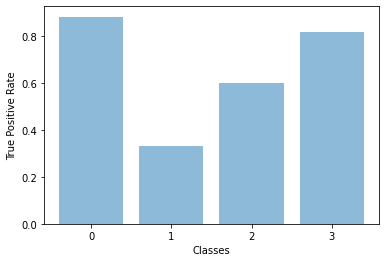

In [25]:
model_without_wl = t.nn.DataParallel(get_vgg_19().cuda())
checkpoint_without_wl = t.load(CHACKPOINT_CROSS_ENTROPY_MODEL)
model_without_wl.load_state_dict(checkpoint_without_wl['model'])
class_acc_no_wl = calculate_class_acc_for_test_set(model_without_wl)
plot_class_acc(class_acc_no_wl)

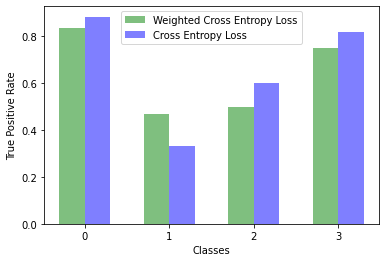

In [26]:
plot_class_acc_comparison(class_acc, class_acc_no_wl, 'Weighted Cross Entropy Loss', 'Cross Entropy Loss')